this is based on `20200827-01-IWCD-SmallerResNetGeom-timeCmplxNCoord-relEposdir`, where I try to add the attention mechanism suggested by Kazu

In [1]:
from __future__ import print_function
import numpy as np
import torch 
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

def geometricPad(grid, pad=1):
  M = grid.shape[2]; # 0:batchsize, 1:channels, 2:width, 3:height
  M_new = pad+M+pad;
  new_shape = (grid.shape[0], grid.shape[1], M_new, M_new)
  grid_new = grid.new_zeros(new_shape);
  grid_new[:,:,pad:M+pad,pad:M+pad] = grid;
  grid_new[:,:,0:pad,pad:(M+pad)] = grid[:,:,:,0:pad].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),0:pad] = grid[:,:,0:pad,:].flip(-2).transpose(-1,-2);
  grid_new[:,:,(M+pad):(M+pad+pad),(pad):(M+pad)] = grid[:,:,:,(M-pad):].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),(M+pad):(M+pad+pad)] = grid[:,:,(M-pad):,:].flip(-2).transpose(-1,-2);
  return(grid_new);

In [2]:
f = h5py.File('/home/lukasb/watchmal/data_ssd/IWCDmPMT_4pi_full_tank/h5_topo/gamma/IWCDmPMT_4pi_full_tank_gamma_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_300.h5','r')
event_data = f['event_data'][:]

In [3]:
f.keys()

<KeysViewHDF5 ['directions', 'energies', 'event_data', 'event_ids', 'labels', 'mGridDirX', 'mGridDirY', 'mGridDirZ', 'mGridPmt', 'mGridX', 'mGridY', 'mGridZ', 'pids', 'positions']>

In [4]:
event_data.shape

(3000, 126, 126, 2)

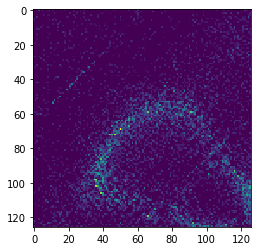

In [5]:
plt.imshow(event_data[5,:,:,0])

In [6]:
mGridCoords = np.stack([
    f['mGridX'][()]/1000.,
    f['mGridY'][()]/1000.,
    f['mGridZ'][()]/1000.,
    f['mGridDirX'][()]*3.,
    f['mGridDirY'][()]*3.,
    f['mGridDirZ'][()]*3.
],2).astype(np.float32)
mGridCoords.shape

(126, 126, 6)

In [7]:
mGridCoords.dtype

dtype('float32')

In [8]:
np.stack([mGridCoords]).shape

(1, 126, 126, 6)

In [9]:
np.broadcast_to(mGridCoords, (3000,126,126,6)).shape

(3000, 126, 126, 6)

In [10]:
(event_data.shape[0],)+mGridCoords.shape

(3000, 126, 126, 6)

In [11]:
np.broadcast_to(mGridCoords, (event_data.shape[0],)+mGridCoords.shape).shape

(3000, 126, 126, 6)

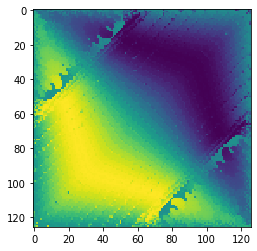

In [12]:
plt.imshow(np.broadcast_to(mGridCoords, (event_data.shape[0],)+mGridCoords.shape)[2,:,:,0])

In [13]:
np.concatenate([event_data, np.broadcast_to(mGridCoords, (event_data.shape[0],)+mGridCoords.shape)],3).shape

(3000, 126, 126, 8)

In [14]:
f['directions'][0:5,:,:]

array([[[-0.7612738 , -0.38697398, -0.5203012 ],
        [-0.7543472 , -0.38718298, -0.5301411 ]],

       [[ 0.05523666,  0.9931533 , -0.10293433],
        [ 0.07299706,  0.98769546, -0.13830794]],

       [[ 0.64005274, -0.69793797, -0.32127103],
        [ 0.6434202 , -0.6932586 , -0.32465816]],

       [[-0.7743332 , -0.11293443, -0.6226186 ],
        [-0.77608013, -0.1117406 , -0.62065583]],

       [[ 0.7777781 , -0.616914  ,  0.12032629],
        [ 0.77494574, -0.6218873 ,  0.11276203]]], dtype=float32)

In [15]:
f['energies'][0:5,:]

array([[  9.6465025,  16.29795  ],
       [ 98.722534 , 752.8345   ],
       [200.3708   , 781.2365   ],
       [593.7564   , 174.11375  ],
       [ 19.46429  , 141.6287   ]], dtype=float32)

In [16]:
p = np.sum(f['directions'][0:5,:,:] * np.expand_dims(f['energies'][0:5,:], 2), 1);
p / np.expand_dims(np.sqrt(np.sum(p*p,1)),1)

array([[-0.7569354 , -0.38711184, -0.5264914 ],
       [ 0.07094387,  0.98840904, -0.13421799],
       [ 0.6427352 , -0.6942163 , -0.32396793],
       [-0.7747298 , -0.11266381, -0.622174  ],
       [ 0.77529174, -0.6212894 ,  0.11367654]], dtype=float32)

In [17]:
f['positions'][0:5,:,:]

array([[[ 226.15565 , -226.87526 , -217.12714 ],
        [ 226.15565 , -226.87526 , -217.12714 ]],

       [[ -84.985435,  121.89317 , -296.89127 ],
        [ -84.985435,  121.89317 , -296.89127 ]],

       [[-111.52647 , -181.44907 , -196.49165 ],
        [-111.52647 , -181.44907 , -196.49165 ]],

       [[-158.23149 ,  207.03516 , -176.26237 ],
        [-158.23149 ,  207.03516 , -176.26237 ]],

       [[ 177.64061 , -197.08856 ,  -98.638115],
        [ 177.64061 , -197.08856 ,  -98.638115]]], dtype=float32)

In [18]:
def imshowRdBu(ax,img):
    minmax = max(torch.max(img),-torch.min(img))
    return ax.imshow(-img,cmap='RdBu',vmin=-minmax,vmax=minmax)

In [41]:
# for the upconvolution we need something like the inverse of geometricPad

def geometricUnpad(grid_new, pad=1):
  # new refers to the input, whereas without the input is just "" (thus consistent with variables in geometricPad)
  M_new = grid_new.shape[2]; # 0:batchsize, 1:channels, 2:width, 3:height
  M     = M_new-2*pad;
  shape = (grid_new.shape[0], grid_new.shape[1], M, M)
  grid = grid_new.new_zeros(shape);
  grid += grid_new[:,:,pad:M+pad,pad:M+pad];
  grid[:,:,:,0:pad] += grid_new[:,:,0:pad,pad:(M+pad)].transpose(-1,-2).flip(-1);
  grid[:,:,0:pad,:] += grid_new[:,:,pad:(M+pad),0:pad].transpose(-1,-2).flip(-2);
  grid[:,:,:,(M-pad):] += grid_new[:,:,(M+pad):(M+pad+pad),(pad):(M+pad)].transpose(-1,-2).flip(-1);
  grid[:,:,(M-pad):,:] += grid_new[:,:,pad:(M+pad),(M+pad):(M+pad+pad)].transpose(-1,-2).flip(-2);
  return(grid);

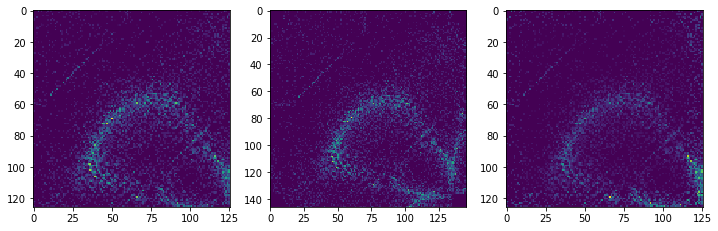

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(12,6),facecolor='w')

x = torch.unsqueeze(torch.as_tensor(event_data[5:6,:,:,0]),1);
xp = geometricPad(x, 10);
xpu = geometricUnpad(xp, 10);
axes[0].imshow(x[0,0,:,:]);
axes[1].imshow(xp[0,0,:,:]);
axes[2].imshow(xpu[0,0,:,:]);

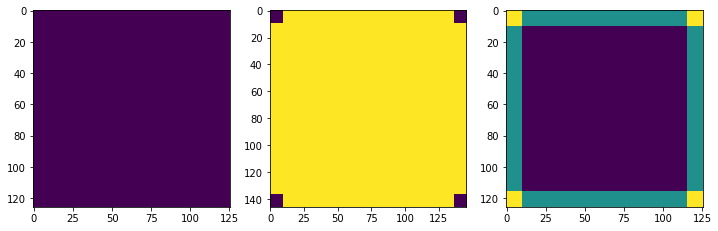

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(12,6),facecolor='w')

x = torch.unsqueeze(torch.as_tensor(event_data[5:6,:,:,0]),1) * 0. + 1.;
xp = geometricPad(x, 10);
xpu = geometricUnpad(xp, 10);
axes[0].imshow(x[0,0,:,:]);
axes[1].imshow(xp[0,0,:,:]);
axes[2].imshow(xpu[0,0,:,:]);

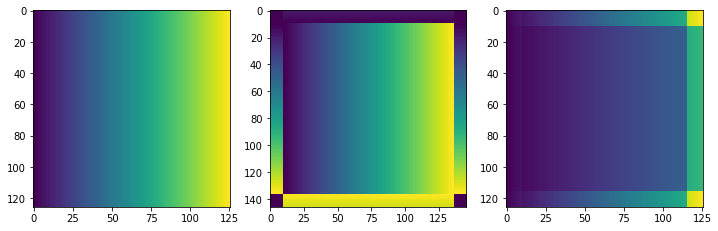

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(12,6),facecolor='w')

x = torch.unsqueeze(torch.as_tensor(event_data[5:6,:,:,0]),1);
x = x * 0. + torch.arange(x.shape[2]);
xp = geometricPad(x, 10);
xpu = geometricUnpad(xp, 10);
axes[0].imshow(x[0,0,:,:]);
axes[1].imshow(xp[0,0,:,:]);
axes[2].imshow(xpu[0,0,:,:]);

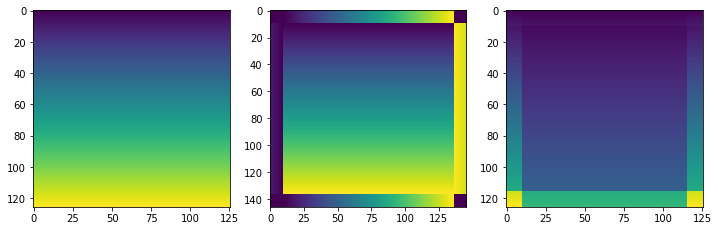

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(12,6),facecolor='w')

x = torch.unsqueeze(torch.as_tensor(event_data[5:6,:,:,0]),1);
x = x * 0. + torch.arange(x.shape[2]).reshape(x.shape[0],x.shape[1],x.shape[2],1);
xp = geometricPad(x, 10);
xpu = geometricUnpad(xp, 10);
axes[0].imshow(x[0,0,:,:]);
axes[1].imshow(xp[0,0,:,:]);
axes[2].imshow(xpu[0,0,:,:]);

## Train network

In [49]:
from torch.utils.data import Dataset, DataLoader

class H5Dataset(Dataset):

    def __init__(self, files, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        # for d in data_dirs:
        #     file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
        #     if limit_num_files: file_list = file_list[0:limit_num_files]
        #     self._files += file_list
        self._files = files

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        label = fh['labels'][entry_index]
        #labelTranslation = [-1,0,1,-1,2] # make sure that labels 1,2,4 get values 0,1,2
        if label == 1: # electron
            label = 0
        elif label == 2: # muon
            label = 1
        elif label == 0: # gamma
            label = 2
        else:
            print('Unknown label', label, 'for entry_index', entry_index, 'treating as label=0')
            label = 0
        
        # try:
        #     label = labelTranslation[label]
        # except IndexError:
        #     print('IndexError at entry', entry_index, 'label in file was', fh['labels'][entry_index], 'translations are', labelTranslation)
        #     raise
        
        event_data = fh['event_data'][entry_index]
        # convert event data to complex rep
        evQ = event_data[:,:,0]
        evT = event_data[:,:,1]
        evR = np.power(evQ,0.25);
        evA = 2*np.pi*(evT-960.)/(1900.-600.)
        evX = evR*np.cos(evA);
        evY = evR*np.sin(evA);
        totalQ = np.sum(evQ)
        
        p = np.sum(fh['directions'][entry_index,:,:] * np.expand_dims(fh['energies'][entry_index,:], 1), 0);
        totdir = p / np.expand_dims(np.sqrt(np.sum(p*p,0)),0)
        
        return np.stack([evX,evY],2),label,idx,fh['positions'][entry_index,0],totdir,np.sum(fh['energies'][entry_index,:]),totalQ
        # the ,0 in positions selects the pos for the first track (in case of gamma)
        # for directions we compute the energy-weighted sum (which is the photon momentum for a gamma)
        # thus positions and directions are just np arrays with 3 elements

def HKCollate(batch):
    data  = np.stack([sample[0] for sample in batch])
    label = [sample[1] for sample in batch]
    idx   = [sample[2] for sample in batch]
    pos   = np.stack([sample[3] for sample in batch])
    direc = np.stack([sample[4] for sample in batch])
    ene   = np.stack([sample[5] for sample in batch])
    totQ  = np.stack([sample[6] for sample in batch])
    return data,label,idx,pos,direc,ene,totQ

In [50]:
mcdir = '/home/lukasb/watchmal/data_ssd/IWCDmPMT_4pi_full_tank/h5_topo'
pnames = ('e-','mu-','gamma')
files = ['%s/%s/IWCDmPMT_4pi_full_tank_%s_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_%d.h5' % (mcdir,pname,pname,bch+100) for bch in range(60) for pname in pnames]

train_ds = H5Dataset(files,start_fraction=0.0,use_fraction=0.9);
test_ds  = H5Dataset(files,start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size=32,shuffle=True,num_workers=4,collate_fn=HKCollate)
# for validation
test_loader =DataLoader( test_ds,batch_size=64,shuffle=True,num_workers=2,collate_fn=HKCollate)

In [51]:
label,positions,directions,energies,totQs=[],[],[],[],[]
for i,data in enumerate(test_loader):
    position  = data[3]
    direction = data[4]
    energy    = data[5]
    totQ      = data[6]
    label.append(data[1])
    positions.append(position)
    directions.append(direction)
    energies.append(energy)
    totQs.append(totQ)
    if i > 50:
        break
label      = np.hstack(label)
positions  = np.vstack(positions)
directions = np.vstack(directions)
energies   = np.concatenate(energies)
totQs      = np.concatenate(totQs)

In [52]:
label.shape

(3328,)

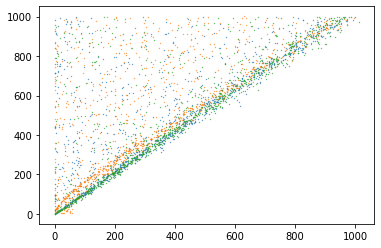

In [53]:
masses = np.array([0.511, 105.7, 0.511*2])
pthres = np.array([0.57,  118.,  0.57 *2])
Ethres = np.sqrt(np.power(masses,2) + np.power(pthres,2))

plt.scatter(totQs[label==0]*0.085, energies[label==0] - Ethres[0], s=0.1)
plt.scatter(totQs[label==1]*0.085, energies[label==1] - Ethres[1], s=0.1)
plt.scatter(totQs[label==2]*0.085, energies[label==2] - Ethres[2], s=0.1)

In [74]:
import torch.nn as nn
import torch.nn.functional as F

# based on https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

class BasicGeomBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicGeomBlock, self).__init__()
        
        self.pad = 1
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=2*self.pad+1, stride=stride, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=2*self.pad+1,
                               stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(geometricPad(x,self.pad))))
        out = self.bn2(self.conv2(geometricPad(out,self.pad)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetGeomAttention(nn.Module):
    def __init__(self, block, num_blocks, num_classes=3):
        super(ResNetGeomAttention, self).__init__()
        overall_in_planes = 8 ## this has been modified to include coord (Q+T+3pos+3dir)
        self.pad = 1
        
        # first attention
        # (1,126,126)
        self.att_conv1 = nn.Conv2d(overall_in_planes, 16, kernel_size=2*self.pad+1,
                               stride=2, padding=0, bias=False)
        self.att_bn1 = nn.BatchNorm2d(16)
        # outsize = floor[(126+2*self.pad-3)/stride + 1]
        # so for stride=1 we have 126,
        #              =2          63 = floor(63.5)
        # the padding is done by geometricPad
        # thus (16,63,63)
        self.att_conv2 = nn.Conv2d(16, 16, kernel_size=2*self.pad+1,
                               stride=2, padding=0, bias=False)
        self.att_bn2 = nn.BatchNorm2d(16)
        # outsize = floor[(63+2*self.pad-3)/stride + 1]
        # so for stride=1 we have 63,
        #              =2         32
        # thus (16,32,32)

        self.in_planes = 16
        self.att_layer1 = self._make_layer(block,  16, num_blocks[0], stride=1)
        #      (16,32,32)
        self.att_layer2 = self._make_layer(block,  16, num_blocks[1], stride=2)
        #      (16,16,16)
        self.att_layer3 = self._make_layer(block,  16, num_blocks[2], stride=2)
        #      (16, 8, 8)
        self.att_layer4 = self._make_layer(block,  16, num_blocks[3], stride=2)
        #      (16, 4, 4)    
        # now we do conv transpose to make the image larger again.
        # conv2d adds "kernel_size-1 - padding" zeros to both sides.
        # since we want to do the padding ourselves witg geometricPad, 
        # we must set the padding argument to (kernel_size-1) = 2*self.pad.
        # on the other hand, the input size will become larger by 2*self.pad
        # because of the geometricPad we do. So
        # insize' = insize + 2*self.pad
        # outsize = (insize'-1)*(stride=2) + (kernel_size=[2*self.pad+1]) - 2*padding + output_padding
        #         = (insize + 2*self.pad - 1)*(stride=2) + (2*self.pad + 1) - 2*(2*self.pad) + output_padding
        #         = (insize + 2*self.pad - 1)*(stride=2) + 1 - 2*self.pad + output_padding
        #         = insize*(stride=2) - 1 + 2*self.pad + output_padding
        self.att_deconv1 = nn.ConvTranspose2d(16, 16, kernel_size=2*self.pad+1, stride=2, padding=0, output_padding=1, bias=False)
        # the 'padding' we will do later ourselves using geometricUnpad, so here we set it to padding=0
        # but in the calculation we use padding=self.pad
        # outsize = (insize-1)*(stride=2) + (kernel_size=[2*self.pad+1]) - 2*(padding=self.pad) + output_padding
        #         = 3*2 + 3 - 2 + output_padding
        #         = 7 + output_padding
        # becuase we want this to be 8, we set output_padding=1
        self.att_dc_bn1 = nn.BatchNorm2d(16)
        # (16, 8, 8)
        self.att_deconv2 = nn.ConvTranspose2d(16, 16, kernel_size=2*self.pad+1, stride=2, padding=0, output_padding=1, bias=False)
        # outsize = (insize-1)*(stride=2) + (kernel_size=[2*self.pad+1]) - 2*(padding=self.pad) + output_padding
        #         = 7*2 + 3 - 2 + output_padding
        #         = 15 + output_padding
        self.att_dc_bn2 = nn.BatchNorm2d(16)
        # outsize = (16,16,16)
        self.att_deconv3 = nn.ConvTranspose2d(16, 1, kernel_size=2*self.pad+1, stride=2, padding=0, output_padding=1, bias=False)
        # outsize = (insize-1)*(stride=2) + (kernel_size=[2*self.pad+1]) - 2*(padding=self.pad) + output_padding
        #         = 15*2 + 3 - 2 + output_padding
        #         = 31 + output_padding
        self.att_dc_bn3 = nn.BatchNorm2d(1)
        # outsize = (1,32,32)
        # this will be our mask, which we pass through a sigmoid function to apply to the (32,32) input to ResNet as mask
        
        # now the standard resnet
        
        # (1,126,126)
        self.conv1 = nn.Conv2d(overall_in_planes, 64, kernel_size=2*self.pad+1,
                               stride=2, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # outsize = floor[(126+2*self.pad-3)/stride + 1]
        # so for stride=1 we have 126,
        #              =2          63 = floor(63.5)
        # the padding is done by geometricPad
        # thus (64,63,63)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=2*self.pad+1,
                               stride=2, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        # outsize = floor[(63+2*self.pad-3)/stride + 1]
        # so for stride=1 we have 63,
        #              =2         32
        # thus (64,32,32)

        self.in_planes = 64
        
        self.layer1 = self._make_layer(block,  64, num_blocks[0], stride=1)
        #      (64,32,32)
        self.layer2 = self._make_layer(block,  64, num_blocks[1], stride=2)
        #      (64,16,16)
        self.layer3 = self._make_layer(block,  64, num_blocks[2], stride=2)
        #      (64, 8, 8)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)
        #      (128,4, 4)
        self.convbn5 = nn.Sequential(
            nn.Conv2d(128,128,kernel_size=4,stride=1,padding=0),
            nn.BatchNorm2d(128)
        )
        #      (128,1, 1)
        # transform to 128, then
        self.linear1 = nn.Linear(int(128*block.expansion),   int(128*block.expansion/2))
        self.linear2 = nn.Linear(int(128*block.expansion/2), int(128*block.expansion/4))
        self.linear3 = nn.Linear(int(128*block.expansion/4), int(128*block.expansion/8))
        self.linear4 = nn.Linear(int(128*block.expansion/8), num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        mask  = self.attention(x)
        
        out = F.relu(self.bn1(self.conv1(geometricPad(x,self.pad))))
        out = F.relu(self.bn2(self.conv2(geometricPad(out,self.pad))))
        out = out * mask # should simply broadcast
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.relu(self.convbn5(out))
        #out = F.avg_pool2d(out, out.shape[2:4])
        out = out.view(out.size(0), -1)
        out = F.relu(self.linear1(out))
        out = F.relu(self.linear2(out))
        out = F.relu(self.linear3(out))
        out = self.linear4(out)
        return out
    
    def attention(self, x):
        # first do the small network for attention
        att0 = F.relu(self.att_bn1(self.att_conv1(geometricPad(x,self.pad))))
        att0 = F.relu(self.att_bn2(self.att_conv2(geometricPad(att0,self.pad))))
        att1 = self.att_layer1(att0)
        att2 = self.att_layer2(att1)
        att3 = self.att_layer3(att2)
        att4 = self.att_layer4(att3)
        # deconvolve. maybe it makes sense to concat the att1,2,3,4 as input
        att3d = F.relu(self.att_dc_bn1(geometricUnpad(self.att_deconv1(att4),self.pad)))
        att2d = F.relu(self.att_dc_bn2(geometricUnpad(self.att_deconv2(att3d),self.pad)))
        mask  = torch.sigmoid(self.att_dc_bn3(geometricUnpad(self.att_deconv3(att2d),self.pad)))
        return mask

#    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
#    
#    def cpu(self):
#        super(GeomCNN, self).cpu()
#        for module in self._feature:
#            module.cpu()
#        for module in self._classifier:
#            module.cpu()
#        return self
#    
#    def cuda(self):
#        super(GeomCNN, self).cuda()
#        for module in self._feature:
#            module.cuda()
#        for module in self._classifier:
#            module.cuda()
#        return self

def ResNetGeomAttention18(num_classes):
    return ResNetGeomAttention(BasicGeomBlock, [2, 2, 2, 2], num_classes)

In [75]:
masses = np.array([0.511, 105.7, 0.511*2])
pthres = np.array([0.57,  118.,  0.57 *2])
Ethres = np.sqrt(np.power(masses,2) + np.power(pthres,2))

def getEnergyPrediction(out):
    out_Eabovethres  = out[:,0:1]
    out_logSigmaESqr = out[:,1:2]
    #print('pred energy', torch.mean(out_Eabovethres), torch.std(out_Eabovethres))
    return out_Eabovethres, out_logSigmaESqr

def getPositionPrediction(out):
    out_pos            = out[:,2:5]
    out_logSigmaPosSqr = out[:,5:6]
    return out_pos, out_logSigmaPosSqr

def getDirectionPrediction(out):
    out_dir            = out[:,6:9]
    out_logSigmaDirSqr = out[:,9:10]
    return out_dir, out_logSigmaDirSqr

def getTrueEnergyAboveThreshold(blob):
    Evis = 0.085*blob.totQ
    out = (blob.energy-Ethres[blob.label] - Evis) / (np.sqrt(500.)*np.sqrt(Evis+0.5))
    #print('true energy', np.mean(out), np.std(out))
    return out

def getNllEnergy(out_Eabovethres, out_logSigmaESqr, true_Eabovethres):
    return 0.5*torch.sum(torch.pow(out_Eabovethres - true_Eabovethres, 2)*torch.exp(-out_logSigmaESqr),1) + 0.5*torch.sum(out_logSigmaESqr,1)

def getNllPosition(out_pos, out_logSigmaPosSqr, true_pos):
    return 0.5*torch.sum(torch.pow(out_pos - true_pos, 2)*torch.exp(-out_logSigmaPosSqr),1) + 0.5*3.*torch.sum(out_logSigmaPosSqr,1)

def getNllDirection(out_dir, out_logSigmaDirSqr, true_dir):
    norm = torch.sqrt(torch.sum(torch.pow(out_dir,2),1))+1e-6 # add 1e-6 to prevent division by 0
    angle = torch.acos(torch.sum(out_dir*true_dir, 1)/norm) # [B]
    return 0.5*torch.pow(angle, 2)*torch.exp(-out_logSigmaDirSqr[:,0]) + 0.5*out_logSigmaDirSqr[:,0] + 0.5*torch.pow(norm-1.,2)/(0.1*0.1)

def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = torch.as_tensor(np.concatenate([blob.data, np.broadcast_to(mGridCoords, (blob.data.shape[0],)+mGridCoords.shape)],3)).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
        data = data.permute(0,3,1,2)
        out = blob.net(data)
        out_Eabovethres,out_Eres = getEnergyPrediction(out)
        out_pos,out_posres       = getPositionPrediction(out)
        out_dir,out_dirres       = getDirectionPrediction(out)
        
        # Training
        nll_energy = getNllEnergy(
            out_Eabovethres,
            out_Eres,
            torch.as_tensor(getTrueEnergyAboveThreshold(blob)).type(torch.FloatTensor).unsqueeze(1).cuda()
        )
        nll_position = getNllPosition(
            out_pos,
            out_posres,
            torch.as_tensor(blob.position/1000.).type(torch.FloatTensor).cuda()
        )
        nll_direction = getNllDirection(
            out_dir,
            out_dirres,
            torch.as_tensor(blob.direction).type(torch.FloatTensor).cuda()
        )
        #print('nll_energy.shape', nll_energy.shape, torch.mean(nll_energy), torch.std(nll_energy))
        #print('nll_position.shape', nll_position.shape, torch.mean(nll_position), torch.std(nll_position))
        loss_energy = torch.sum(nll_energy)
        loss_position = torch.sum(nll_position)
        loss_direction = torch.sum(nll_direction)
        loss = loss_energy + loss_position + loss_direction
        blob.loss = loss
        
        batchSize = float(out.shape[0])
        mean_chi2_E   = 2.*loss_energy  .cpu().detach().item() / batchSize
        mean_chi2_pos = 2.*loss_position.cpu().detach().item() / 3*batchSize
        mean_chi2_dir = 2.*loss_direction.cpu().detach().item() / batchSize
        mean_Eres   = torch.exp(torch.mean(out_Eres  )).cpu().detach().item()
        mean_posres = torch.exp(torch.mean(out_posres)).cpu().detach().item()
        mean_dirres = torch.exp(torch.mean(out_dirres)).cpu().detach().item()
        
        return {'pred_Eabovethres' : out_Eabovethres.cpu().detach().numpy(),
                'pred_Eres'        : out_Eres       .cpu().detach().numpy(),
                'pred_position'    : out_pos        .cpu().detach().numpy(),
                'pred_positionres' : out_posres     .cpu().detach().numpy(),
                'pred_direction'    : out_dir        .cpu().detach().numpy(),
                'pred_directionres' : out_dirres     .cpu().detach().numpy(),
                'loss_energy'   : loss_energy  .cpu().detach().item(),
                'loss_position' : loss_position.cpu().detach().item(),
                'loss_direction': loss_direction.cpu().detach().item(),
                'loss'         : loss         .cpu().detach().item(),
                'mean_chi2_E'   : mean_chi2_E,
                'mean_chi2_pos' : mean_chi2_pos,
                'mean_chi2_dir' : mean_chi2_dir,
                'mean_Eres'     : mean_Eres,
                'mean_posres'   : mean_posres,
                'mean_dirres'   : mean_dirres,
               }

resKeysToLog = ['loss_energy','loss_position','loss_direction','loss','mean_chi2_E','mean_chi2_pos','mean_chi2_dir','mean_Eres','mean_posres','mean_dirres']
    
def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()

def save_state(blob):
    # Output file name
    filename = '%s-%d.ckpt' % (blob.prefix, blob.iteration)
    # Save parameters
    # 0+1) iteration counter + optimizer state => in case we want to "continue training" later
    # 2) network weight
    torch.save({
        'global_epoch': blob.epoch,
        'global_step': blob.iteration,
        'optimizer': blob.optimizer.state_dict(),
        'state_dict': blob.net.state_dict()
        }, filename)
    return filename

def restore_state(blob, iteration):
    # Open a file in read-binary mode
    weight_file = '%s-%d.ckpt' % (blob.prefix, iteration)
    with open(weight_file, 'rb') as f:
        # torch interprets the file, then we can access using string keys
        checkpoint = torch.load(f)
        # load network weights
        blob.net.load_state_dict(checkpoint['state_dict'], strict=False)
        # if optimizer is provided, load the state of the optimizer
        if blob.optimizer is not None:
            blob.optimizer.load_state_dict(checkpoint['optimizer'])
        # load iteration count
        blob.epoch     = checkpoint['global_epoch']
        blob.iteration = checkpoint['global_step']

# weight_file = save_state(blob, '20190819-02-DeepTaylor-01-BatchNorm')
# print('Saved to', weight_file)


# # Recreate the network (i.e. initialize)
# blob.net=LeNet().cuda()
# # Get one batch of data to test
# blob.data, blob.label = next(iter(train_loader))
# # Run forward function
# res = forward(blob,True)
# # Report
# print('Accuracy:',res['accuracy'])



# # Restore the state
# restore_state(weight_file,blob)
# # Run the forward function
# res = forward(blob,True)
# # Report
# print('Accuracy',res['accuracy'])

In [76]:
class BLOB:
    pass
blob=BLOB()
blob.net       = ResNetGeomAttention18(10).cuda() # E,Eres,pos[3],posres,dir[3],dirres
# just the training weights is ~700MiB
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.prefix    = '20200831-01-IWCD-SRNGattention-timeCmplxNCoord-relEposdir-01-relEposdir'
blob.epoch     = 0.
blob.iteration = 0
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [77]:
print(torch.sqrt(torch.mean(torch.pow(torch.as_tensor(mGridCoords),2),(0,1))))

tensor([0.2401, 0.3503, 0.2401, 1.8098, 1.5526, 1.8098])


In [78]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('%s-log_train.csv' % blob.prefix), CSVData('%s-log_test.csv' % blob.prefix)

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=4.0
# Set the network to training mode
blob.net.train()

# Start training
while int(blob.epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(blob.epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        # data,label,idx,pos,direc,ene
        blob.data,blob.label = data[0:2]
        blob.position  = data[3]
        blob.direction = data[4]
        blob.energy    = data[5]
        blob.totQ      = data[6]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        blob.epoch += 1./len(train_loader)
        blob.iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch']+resKeysToLog,[blob.iteration,blob.epoch]+[res[key] for key in resKeysToLog])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f = %1.3f (energy) + %1.3f (pos) + %1.3f (dir)' % (blob.iteration,blob.epoch,res['loss'],res['loss_energy'],res['loss_position'],res['loss_direction'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                blob.position  = test_data[3]
                blob.direction = test_data[4]
                blob.energy    = test_data[5]
                blob.totQ      = test_data[6]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch']+resKeysToLog,[blob.iteration,blob.epoch]+[res[key] for key in resKeysToLog])
                blob.test_log.write()
            blob.net.train()
        # even more rarely, save state
        if (i+1)%400 == 0:
            with torch.no_grad():
                blob.net.eval()
                save_state(blob)
            blob.net.train()
        if blob.epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f = %1.3f (energy) + %1.3f (pos) + %1.3f (dir)' % (blob.iteration,blob.epoch,res['loss'],res['loss_energy'],res['loss_position'],res['loss_direction'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2020-08-31 23:12:32


Epoch 1 Starting @ 2020-08-31 23:39:20


Epoch 2 Starting @ 2020-09-01 00:06:13


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [79]:
save_state(blob)

'20200831-01-IWCD-SRNGattention-timeCmplxNCoord-relEposdir-01-relEposdir-60752.ckpt'

In [80]:
# restore_state(blob, 10128)

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)
ax1.set_ylim(-800.,300.)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.mean_chi2_E, linewidth=2, label='Train E <chi2>', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.mean_chi2_E, marker='o', markersize=12, linestyle='', label='Test E <chi2>', color='red')

ax2.set_ylabel('E <chi2>', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(-5.,10.)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

ParserError: Error tokenizing data. C error: Expected 12 fields in line 140, saw 14


In [82]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)
ax1.set_ylim(-800.,300.)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.mean_Eres, linewidth=2, label='Train <σ> energy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.mean_Eres, marker='o', markersize=12, linestyle='', label='Test <σ> energy', color='red')

ax2.set_ylabel('<σ> energy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,10.)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

ParserError: Error tokenizing data. C error: Expected 12 fields in line 140, saw 14


In [83]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss_energy, linewidth=2, label='Train E loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss_energy, marker='o', markersize=12, linestyle='', label='Test E loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('E loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)
ax1.set_ylim(-150.,200.)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.loss_position, linewidth=2, label='Train pos loss', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.loss_position, marker='o', markersize=12, linestyle='', label='Test pos loss', color='red')
ax2.set_ylabel('Pos loss', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(-800.,0.)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

ParserError: Error tokenizing data. C error: Expected 12 fields in line 140, saw 14


In [84]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss_direction, linewidth=2, label='Train dir loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss_direction, marker='o', markersize=12, linestyle='', label='Test dir loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Direction loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)
ax1.set_ylim(-150.,200.)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.loss_position, linewidth=2, label='Train pos loss', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.loss_position, marker='o', markersize=12, linestyle='', label='Test pos loss', color='red')
ax2.set_ylabel('Pos loss', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(-800.,0.)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

ParserError: Error tokenizing data. C error: Expected 12 fields in line 140, saw 14


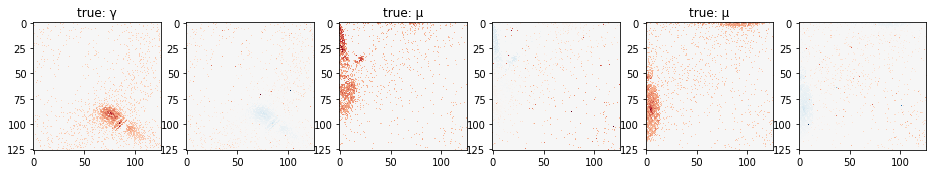

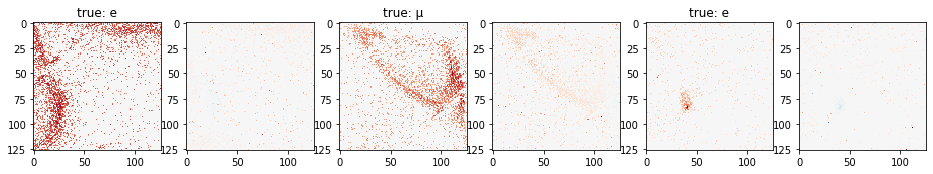

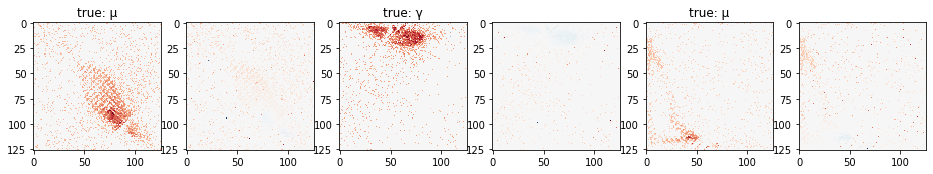

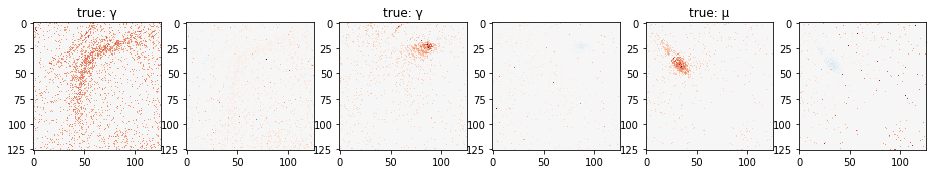

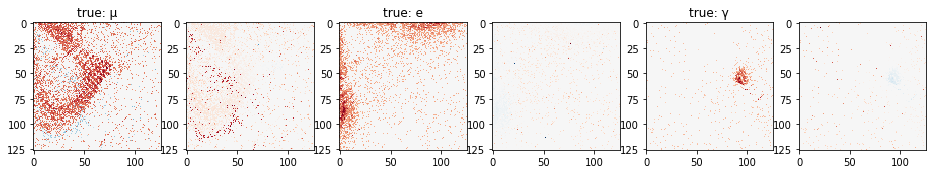

In [85]:
with torch.no_grad():
    Nrows = 5
    for r in range(Nrows):
        Nplot = 6
        fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')

        with torch.no_grad():
            blob.net.eval()
            test_data = next(iter(test_loader))
            blob.data,blob.label = test_data[0:2]
            blob.position = test_data[3]
            blob.direction= test_data[4]
            blob.energy   = test_data[5]
            blob.totQ     = test_data[6]
            # limit the number of events to run the network on
            # blob.data  = blob.data[0:Nplot,:,:,:]
            # blob.label = blob.label[0:Nplot]
            # blob.position = blob.position[0:Nplot,:]
            # blob.energy = blob.energy[0:Nplot,:]
            # blob.totQ = blob.totQ[0:Nplot,:]
            res = forward(blob,train=False)
            
            plotted = 0
            for ev in range(blob.data.shape[0]):
                if plotted >= int(Nplot/2):
                    break
                sigDir = np.exp(0.5*res['pred_directionres'][ev,0])/np.pi*180.
                if sigDir > 15.:
                    continue # we only want events with predicted resolution better than 15 cm
                for qt in range(2):
                    #im = axes[2*ev+qt].imshow(blob.data[ev,:,:,qt])
                    imshowRdBu(axes[2*plotted+qt], torch.as_tensor(blob.data[ev,:,:,qt]))
                    labelNames = ['e','μ','γ']
                    if qt == 0:
                        axes[2*plotted+qt].set_title('true: %s' % (labelNames[blob.label[ev]]))
                plotted += 1
                #cbar = fig.colorbar(im, ax=axes[0])
            plt.show()
            
            del test_data
            del blob.data
            del blob.label

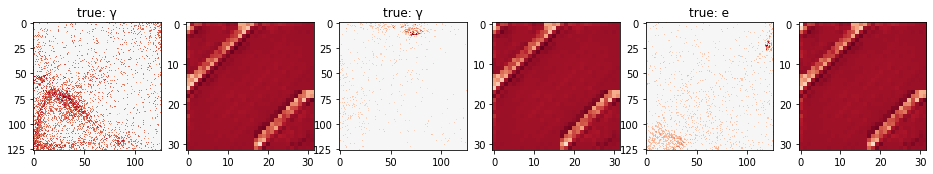

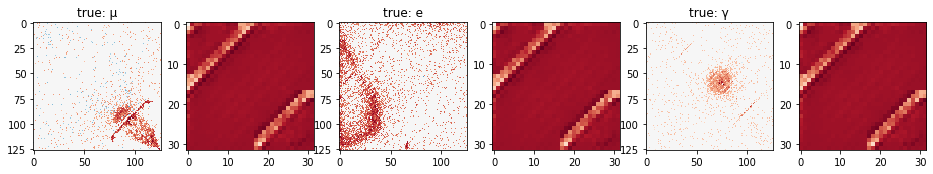

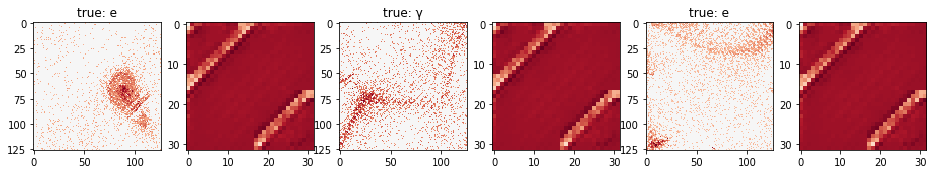

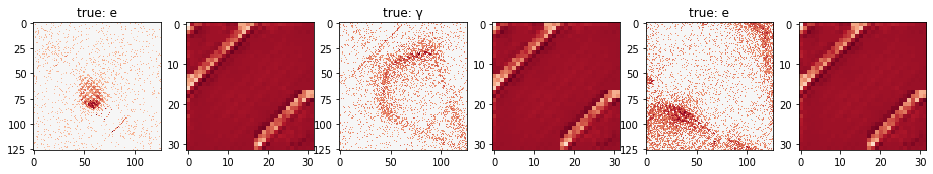

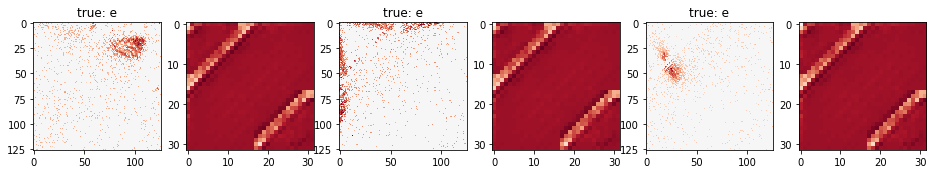

In [87]:
# try to plot attention mask

with torch.no_grad():
    Nrows = 5
    for r in range(Nrows):
        Nplot = 6
        fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')

        with torch.no_grad():
            blob.net.eval()
            test_data = next(iter(test_loader))
            blob.data,blob.label = test_data[0:2]
            blob.position = test_data[3]
            blob.direction= test_data[4]
            blob.energy   = test_data[5]
            blob.totQ     = test_data[6]
            # limit the number of events to run the network on
            # blob.data  = blob.data[0:Nplot,:,:,:]
            # blob.label = blob.label[0:Nplot]
            # blob.position = blob.position[0:Nplot,:]
            # blob.energy = blob.energy[0:Nplot,:]
            # blob.totQ = blob.totQ[0:Nplot,:]
            res = forward(blob,train=False)
            
            mask_data = torch.as_tensor(np.concatenate([blob.data, np.broadcast_to(mGridCoords, (blob.data.shape[0],)+mGridCoords.shape)],3)).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
            mask_data = mask_data.permute(0,3,1,2)
            mask = blob.net.attention(mask_data).cpu()
            del mask_data
            
            plotted = 0
            for ev in range(blob.data.shape[0]):
                if plotted >= int(Nplot/2):
                    break
                sigDir = np.exp(0.5*res['pred_directionres'][ev,0])/np.pi*180.
                if sigDir > 15.:
                    continue # we only want events with predicted resolution better than 15 cm
                imshowRdBu(axes[2*plotted+0], torch.as_tensor(blob.data[ev,:,:,0]))
                imshowRdBu(axes[2*plotted+1], torch.as_tensor(mask[ev,0,:,:]))
                labelNames = ['e','μ','γ']
                axes[2*plotted].set_title('true: %s' % (labelNames[blob.label[ev]]))
                plotted += 1
                #cbar = fig.colorbar(im, ax=axes[0])
            plt.show()
            
            del test_data
            del blob.data
            del blob.label

In [ ]:
def inferenceWithSoftmax(blob,data_loader):
    label,pred_Eabovethres,pred_logSigmaESqr,pred_position,pred_logSigmaPosSqr,pred_direction,pred_logSigmaDirSqr,positions,directions,energies=[],[],[],[],[],[],[],[],[],[]
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    index,label,prediction = [],[],[]
    for i,data in enumerate(data_loader):
        blob.data, blob.label = data[0:2]
        blob.position  = data[3]
        blob.direction = data[4]
        blob.energy    = data[5]
        blob.totQ      = data[6]
        totQ           = data[6]
        res = forward(blob,train=False)
        
        Evis = np.expand_dims(0.085*blob.totQ, -1)
        pred_Eabovethres.append(res['pred_Eabovethres']*(np.sqrt(500.)*np.sqrt(Evis+0.5)) + Evis)
        pred_logSigmaESqr.append(res['pred_Eres'])
        pred_position.append(res['pred_position'])
        pred_logSigmaPosSqr.append(res['pred_positionres'])
        pred_direction.append(res['pred_direction'])
        pred_logSigmaDirSqr.append(res['pred_directionres'])
        
        label.append(blob.label)
        positions.append(blob.position)
        directions.append(blob.direction)
        energies.append(blob.energy)
        #if i==2: break
    # report accuracy
    pred_Eabovethres      = np.vstack(pred_Eabovethres)
    pred_logSigmaESqr     = np.vstack(pred_logSigmaESqr)
    pred_position         = np.vstack(pred_position)
    pred_logSigmaPosSqr   = np.vstack(pred_logSigmaPosSqr)
    pred_direction        = np.vstack(pred_direction)
    pred_logSigmaDirSqr   = np.vstack(pred_logSigmaDirSqr)
    label      = np.hstack(label)
    positions  = np.vstack(positions)
    directions = np.vstack(directions)
    energies   = np.concatenate(energies)
    
    return pred_Eabovethres, pred_logSigmaESqr, pred_position, pred_logSigmaPosSqr, pred_direction, pred_logSigmaDirSqr, label, positions, directions, energies

In [ ]:
pred_Eabovethres, pred_logSigmaESqr, pred_position, pred_logSigmaPosSqr, pred_direction, pred_logSigmaDirSqr, label, positions, directions, energies = inferenceWithSoftmax(blob,test_loader)

In [ ]:
dwall_caps = 520. - np.abs(positions[:,1]);
dwall_barrel = 370. - np.sqrt(positions[:,0]**2 + positions[:,2]**2);
dwall = np.amin(np.stack([dwall_caps,dwall_barrel]),0);

In [ ]:
print(pred_Eabovethres.shape)
print(energies.shape)
print(np.expand_dims(blob.totQ, -1).shape)
print(pred_logSigmaESqr.shape)

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter((energies - Ethres[label])[label==0], (pred_Eabovethres)[label == 0], s=0.4, alpha=0.5, label='true e');
plt.scatter((energies - Ethres[label])[label==1], (pred_Eabovethres)[label == 1], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('True energy above thres');
plt.ylabel('Pred energy above thres');
plt.show();

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter((energies - Ethres[label])[label==0], (np.exp(0.5*pred_logSigmaESqr))[label == 0], s=0.4, alpha=0.5, label='true e');
plt.scatter((energies - Ethres[label])[label==1], (np.exp(0.5*pred_logSigmaESqr))[label == 1], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('True energy above thres');
plt.ylabel('Pred energy resolution [a.u.]')
plt.yscale('log')
plt.show();

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))[label==0], (np.exp(0.5*pred_logSigmaESqr))[label == 0], s=0.4, alpha=0.5, label='true e');
plt.scatter((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))[label==1], (np.exp(0.5*pred_logSigmaESqr))[label == 1], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('Pred - true energy above thres [MeV]');
plt.ylabel('Pred energy resolution [a.u.]')
plt.yscale('log')
plt.show();

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter(np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))[label==0], (np.exp(0.5*pred_logSigmaESqr))[label == 0], s=0.4, alpha=0.5, label='true e');
plt.scatter(np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))[label==1], (np.exp(0.5*pred_logSigmaESqr))[label == 1], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('|Pred - true| energy above thres [MeV]');
plt.ylabel('Pred energy resolution [a.u.]')
plt.xscale('log')
plt.yscale('log')
plt.show();

In [ ]:
print((energies - Ethres[label]).shape)
print(pred_Eabovethres.shape)

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = sigE < 2e-1

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], (pred_Eabovethres)[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], (pred_Eabovethres)[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('True energy above thres');
plt.ylabel('Pred energy above thres');
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = sigE < 2e-1

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('True energy above thres');
plt.ylabel('Relative energy misprediction');
plt.ylim(-0.30,0.30)
plt.plot([0.,1e3],[0.,0.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = sigE > 2e-1

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('True energy above thres');
plt.ylabel('Relative energy misprediction');
plt.ylim(-2.,2.)
plt.plot([0.,1e3],[0.,0.],'--')
plt.show();

In [ ]:
plt.hist(sigE[sigE<1.],bins=50);

In [ ]:
print(pred_position.shape)
print(positions.shape)

In [ ]:
plt.hist(pred_position[:,0])

In [ ]:
plt.hist(positions[:,0])

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter((energies - Ethres[label])[label==0], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 0], s=0.4, alpha=0.5, label='true e');
plt.scatter((energies - Ethres[label])[label==1], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 1], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('True energy above thres');
plt.ylabel('Distance between true and pred position [cm]');
plt.yscale('log')
plt.show();

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter((energies - Ethres[label])[label==0], (np.exp(0.5*pred_logSigmaPosSqr)*1000.)[label == 0], s=0.4, alpha=0.5, label='true e');
plt.scatter((energies - Ethres[label])[label==1], (np.exp(0.5*pred_logSigmaPosSqr)*1000.)[label == 1], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('True energy above thres');
plt.ylabel('Pred pos resolution [cm]')
plt.yscale('log')
plt.show();

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter((np.exp(0.5*pred_logSigmaPosSqr)*1000.)[label == 0], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 0], s=0.4, alpha=0.5, label='true e');
plt.scatter((np.exp(0.5*pred_logSigmaPosSqr)*1000.)[label == 1], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 1], s=0.4, alpha=0.5, label='true mu');
plt.plot([1e1,3e2], [1e1,3e2], '--')
plt.legend(loc='upper right');
plt.xlabel('Pred pos resolution [cm]')
plt.ylabel('Distance between true and pred position [cm]')
plt.xscale('log')
plt.yscale('log')
plt.show();

In [ ]:
dPos = np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1));
plt.hist(dPos,bins=50);
plt.xlabel('Distance between true and pred position [cm]');
plt.yscale('log');

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr)*1000.;
plt.hist(sigPos,bins=50);
plt.xlabel('Pred pos resolution [cm]')
plt.yscale('log');

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(dwall[np.logical_and(cut,label==0)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(dwall[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('Distance to nearest wall [cm]');
plt.ylabel('Relative energy misprediction');
plt.ylim(-1.,1.)
plt.plot([0.,300.],[0.,0.],'--')
plt.show();

In [ ]:
tankZ = 520. + 1.
tankR = 370. + 1.
# [x,y,z] = pos + t*dir
# x^2 + y^2 = R^2
# = (x0 + t*dx)^2 + (y0 + t*dy)^2
# = x0^2 + 2t * x0*dx + t^2 * dx^2
# 0 = t^2 + 2(x0.dx) t + (x0^2 - R^2)
# t = - (x0.dx) + sqrt[(x0.dx)^2 - (x0^2 - R^2)]
exitpoint_barrel_x0dx = positions[:,0]*directions[:,0] + positions[:,2]*directions[:,2]
exitpoint_barrel_x0x0 = positions[:,0]**2 + positions[:,2]**2
exitpoint_barrel_insqrt = exitpoint_barrel_x0dx**2 + tankR**2 - exitpoint_barrel_x0x0
exitpoint_barrel_t = np.where(exitpoint_barrel_insqrt>0., -exitpoint_barrel_x0dx + np.sqrt(np.where(exitpoint_barrel_insqrt>0.,exitpoint_barrel_insqrt,0.)), np.nan)
exitpoint_barrel = positions + np.expand_dims(exitpoint_barrel_t,-1) * directions

# tankZ = z = pos + t*dir
# t = (tankZ - pos_z)/dir_z
exitpoint_cap_t = (np.where(directions[:,1]>0., tankZ, -tankZ) - positions[:,1]) / directions[:,1]
exitpoint_cap = positions + np.expand_dims(exitpoint_cap_t,-1) * directions

towall = np.where(np.logical_or(np.isnan(exitpoint_barrel_t),np.abs(np.where(np.isnan(exitpoint_barrel_t),0.,exitpoint_barrel[:,1])) > tankZ), exitpoint_cap_t, exitpoint_barrel_t)

In [ ]:
plt.hist(towall)

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Relative energy misprediction');
plt.ylim(-1.,1.)
plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], sigE[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], sigE[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true mu');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Predicted relative energy uncertainty');
plt.ylim(0.,2.)
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE < 0.2) # only good events

fig = plt.figure(figsize=[10,6])
plt.hist(towall[np.logical_and(cut,label==0)], alpha=0.5, label='true e')
plt.hist(towall[np.logical_and(cut,label==1)], alpha=0.5, label='true μ')
plt.hist(towall[np.logical_and(cut,label==2)], alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Distance between true and pred position [cm]');
plt.yscale('log')
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], sigPos[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], sigPos[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], sigPos[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Predicted position resolution [cm]');
plt.yscale('log')
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos < 30.) # better than 30 cm

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Distance between true and pred position [cm]');
plt.yscale('log')
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos < 30.) # better than 30 cm

bins = np.linspace(0., 200., 100)

fig = plt.figure(figsize=[10,6])
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Distance between true and pred position [cm]');
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 0.) # all events

bins = np.linspace(0., 700., 100)

fig = plt.figure(figsize=[10,6])
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==0)], alpha=0.5, label='true e', bins=bins)
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==1)], alpha=0.5, label='true μ', bins=bins)
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==2)], alpha=0.5, label='true γ', bins=bins)
plt.legend(loc='upper right');
plt.xlabel('Distance between true and pred position [cm]');
plt.yscale('log')
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 0.) # all events

bins = np.linspace(0., 350., 100)

fig = plt.figure(figsize=[10,6])
plt.hist(sigPos[np.logical_and(cut,label==0)], alpha=0.5, label='true e', bins=bins)
plt.hist(sigPos[np.logical_and(cut,label==1)], alpha=0.5, label='true μ', bins=bins)
plt.hist(sigPos[np.logical_and(cut,label==2)], alpha=0.5, label='true γ', bins=bins)
plt.legend(loc='upper right');
plt.xlabel('Predicted position resolution [cm]');
plt.yscale('log')
plt.show();

In [ ]:
sigDir = np.exp(0.5*pred_logSigmaDirSqr[:,0])
cut = (sigDir > 0) # should be all events

theta = np.arccos(np.sum(pred_direction*directions,1)/np.sqrt(np.sum(np.power(pred_direction,2),1)))

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], (theta/np.pi*180.)[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], (theta/np.pi*180.)[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], (theta/np.pi*180.)[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Angle between true and pred direction [deg]');
plt.yscale('log')
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigDir = np.exp(0.5*pred_logSigmaDirSqr[:,0])
cut = (sigDir > 0) # should be all events

theta = np.arccos(np.sum(pred_direction*directions,1)/np.sqrt(np.sum(np.power(pred_direction,2),1)))

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], (sigDir/np.pi*180.)[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], (sigDir/np.pi*180.)[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], (sigDir/np.pi*180.)[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Predicted direction resolution [deg]');
plt.yscale('log')
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigDir = np.exp(0.5*pred_logSigmaDirSqr[:,0])
cut = (sigDir/np.pi*180. < 15.) # better than 15 deg

theta = np.arccos(np.sum(pred_direction*directions,1)/np.sqrt(np.sum(np.power(pred_direction,2),1)))

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], (theta/np.pi*180.)[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], (theta/np.pi*180.)[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], (theta/np.pi*180.)[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Angle between true and pred direction [deg]');
plt.yscale('log')
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigDir = np.exp(0.5*pred_logSigmaDirSqr[:,0])
cut = (sigDir/np.pi*180. < 15.) # better than 15 deg

theta = np.arccos(np.sum(pred_direction*directions,1)/np.sqrt(np.sum(np.power(pred_direction,2),1)))

bins = np.linspace(0., 50., 100)
fig = plt.figure(figsize=[10,6])
plt.hist((theta/np.pi*180.)[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist((theta/np.pi*180.)[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist((theta/np.pi*180.)[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Angle between true and pred direction [deg]');
plt.show();

In [ ]:
sigDir = np.exp(0.5*pred_logSigmaDirSqr[:,0])
cut = (sigDir/np.pi*180. > 0.) # all events

theta = np.arccos(np.sum(pred_direction*directions,1)/np.sqrt(np.sum(np.power(pred_direction,2),1)))

bins = np.linspace(0., 180., 100)
fig = plt.figure(figsize=[10,6])
plt.hist((theta/np.pi*180.)[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist((theta/np.pi*180.)[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist((theta/np.pi*180.)[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Angle between true and pred direction [deg]');
plt.yscale('log')
plt.show();

In [ ]:
with torch.no_grad():
    Nrows = 5
    for r in range(Nrows):
        Nplot = 6
        fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')

        with torch.no_grad():
            blob.net.eval()
            test_data = next(iter(test_loader))
            blob.data,blob.label = test_data[0:2]
            blob.position = test_data[3]
            blob.direction= test_data[4]
            blob.energy   = test_data[5]
            blob.totQ     = test_data[6]
            # limit the number of events to run the network on
            # blob.data  = blob.data[0:Nplot,:,:,:]
            # blob.label = blob.label[0:Nplot]
            # blob.position = blob.position[0:Nplot,:]
            # blob.energy = blob.energy[0:Nplot,:]
            # blob.totQ = blob.totQ[0:Nplot,:]
            res = forward(blob,train=False)
            
            plotted = 0
            for ev in range(blob.data.shape[0]):
                if plotted >= int(Nplot/2):
                    break
                sigDir = np.exp(0.5*res['pred_directionres'][ev,0])/np.pi*180.
                if sigDir < 15.:
                    continue # we only want events with predicted resolution worse than 15 cm
                for qt in range(2):
                    #im = axes[2*ev+qt].imshow(blob.data[ev,:,:,qt])
                    imshowRdBu(axes[2*plotted+qt], torch.as_tensor(blob.data[ev,:,:,qt]))
                    labelNames = ['e','μ','γ']
                    if qt == 0:
                        axes[2*plotted+qt].set_title('true: %s' % (labelNames[blob.label[ev]]))
                plotted += 1
                #cbar = fig.colorbar(im, ax=axes[0])
            plt.show()
            
            del test_data
            del blob.data
            del blob.label

In [ ]:
with torch.no_grad():
    Nrows = 5
    for r in range(Nrows):
        Nplot = 6
        fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')

        with torch.no_grad():
            blob.net.eval()
            test_data = next(iter(test_loader))
            blob.data,blob.label = test_data[0:2]
            blob.position = test_data[3]
            blob.direction= test_data[4]
            blob.energy   = test_data[5]
            blob.totQ     = test_data[6]
            # limit the number of events to run the network on
            # blob.data  = blob.data[0:Nplot,:,:,:]
            # blob.label = blob.label[0:Nplot]
            # blob.position = blob.position[0:Nplot,:]
            # blob.energy = blob.energy[0:Nplot,:]
            # blob.totQ = blob.totQ[0:Nplot,:]
            res = forward(blob,train=False)
            
            plotted = 0
            for ev in range(blob.data.shape[0]):
                if plotted >= int(Nplot/2):
                    break
                sigDir = np.exp(0.5*res['pred_directionres'][ev,0])/np.pi*180.
                if sigDir > 15.:
                    continue # we only want events with predicted resolution better than 15 cm
                for qt in range(2):
                    #im = axes[2*ev+qt].imshow(blob.data[ev,:,:,qt])
                    imshowRdBu(axes[2*plotted+qt], torch.as_tensor(blob.data[ev,:,:,qt]))
                    labelNames = ['e','μ','γ']
                    if qt == 0:
                        axes[2*plotted+qt].set_title('true: %s' % (labelNames[blob.label[ev]]))
                plotted += 1
                #cbar = fig.colorbar(im, ax=axes[0])
            plt.show()
            
            del test_data
            del blob.data
            del blob.label

In [ ]:
for a in [pred_Eabovethres, pred_logSigmaESqr, pred_position, pred_logSigmaPosSqr, pred_direction, pred_logSigmaDirSqr, label, positions, directions, energies]:
    print(a.shape)

In [ ]:
#label,prediction,softmax,positions,directions
np.savetxt('%s-inferenceEpos.csv' % blob.prefix,
           np.hstack([pred_Eabovethres, pred_logSigmaESqr, pred_position, pred_logSigmaPosSqr, pred_direction, pred_logSigmaDirSqr, np.expand_dims(label,1), positions, directions, np.expand_dims(energies,1)]),
           delimiter=','
          )

## Train for 4 more epochs with more data

In [ ]:
mcdir = '/home/lukasb/watchmal/data_ssd/IWCDmPMT_4pi_full_tank/h5_topo'
pnames = ('e-','mu-','gamma')
files = ['%s/%s/IWCDmPMT_4pi_full_tank_%s_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_%d.h5' % (mcdir,pname,pname,bch+100) for bch in range(300) for pname in pnames]

train_ds = H5Dataset(files,start_fraction=0.0,use_fraction=0.9);
test_ds  = H5Dataset(files,start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size=32,shuffle=True,num_workers=4,collate_fn=HKCollate)
# for validation
test_loader =DataLoader( test_ds,batch_size=64,shuffle=True,num_workers=2,collate_fn=HKCollate)

In [ ]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('%s-log_train_epoch4to8.csv' % blob.prefix), CSVData('%s-log_test_epoch4to8.csv' % blob.prefix)

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=8.0
# Set the network to training mode
blob.net.train()

# Start training
while int(blob.epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(blob.epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        # data,label,idx,pos,direc,ene
        blob.data,blob.label = data[0:2]
        blob.position = data[3]
        blob.direction= data[4]
        blob.energy   = data[5]
        blob.totQ     = data[6]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        blob.epoch += 1./len(train_loader)
        blob.iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch']+resKeysToLog,[blob.iteration,blob.epoch]+[res[key] for key in resKeysToLog])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f = %1.3f (energy) + %1.3f (pos) + %1.3f (dir)' % (blob.iteration,blob.epoch,res['loss'],res['loss_energy'],res['loss_position'],res['loss_direction'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                blob.position = test_data[3]
                blob.direction= test_data[4]
                blob.energy   = test_data[5]
                blob.totQ     = test_data[6]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch']+resKeysToLog,[blob.iteration,blob.epoch]+[res[key] for key in resKeysToLog])
                blob.test_log.write()
            blob.net.train()
        # even more rarely, save state
        if (i+1)%400 == 0:
            with torch.no_grad():
                blob.net.eval()
                save_state(blob)
            blob.net.train()
        if blob.epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f = %1.3f (energy) + %1.3f (pos) + %1.3f (dir)' % (blob.iteration,blob.epoch,res['loss'],res['loss_energy'],res['loss_position'],res['loss_direction'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

In [ ]:
save_state(blob)

In [ ]:
pred_Eabovethres, pred_logSigmaESqr, pred_position, pred_logSigmaPosSqr, pred_direction, pred_logSigmaDirSqr, label, positions, directions, energies = inferenceWithSoftmax(blob,test_loader)

In [ ]:
#label,prediction,softmax,positions,directions
np.savetxt('%s-inferenceEpos_epoch8.csv' % blob.prefix,
           np.hstack([pred_Eabovethres, pred_logSigmaESqr, pred_position, pred_logSigmaPosSqr, np.expand_dims(label,1), positions, directions, np.expand_dims(energies,1)]),
           delimiter=','
          )

In [ ]:
infData = np.loadtxt('%s-inferenceEpos_epoch8.csv' % blob.prefix, delimiter=',')

In [ ]:
pred_Eabovethres, pred_logSigmaESqr, pred_position, pred_logSigmaPosSqr, label, positions, directions, energies = infData[:,0:1],infData[:,1:2],infData[:,2:5],infData[:,5:6],infData[:,6].astype(int),infData[:,7:10],infData[:,10:13],infData[:,13]

In [ ]:
tankZ = 520. + 1.
tankR = 370. + 1.
# [x,y,z] = pos + t*dir
# x^2 + y^2 = R^2
# = (x0 + t*dx)^2 + (y0 + t*dy)^2
# = x0^2 + 2t * x0*dx + t^2 * dx^2
# 0 = t^2 + 2(x0.dx) t + (x0^2 - R^2)
# t = - (x0.dx) + sqrt[(x0.dx)^2 - (x0^2 - R^2)]
exitpoint_barrel_x0dx = positions[:,0]*directions[:,0] + positions[:,2]*directions[:,2]
exitpoint_barrel_x0x0 = positions[:,0]**2 + positions[:,2]**2
exitpoint_barrel_insqrt = exitpoint_barrel_x0dx**2 + tankR**2 - exitpoint_barrel_x0x0
exitpoint_barrel_t = np.where(exitpoint_barrel_insqrt>0., -exitpoint_barrel_x0dx + np.sqrt(np.where(exitpoint_barrel_insqrt>0.,exitpoint_barrel_insqrt,0.)), np.nan)
exitpoint_barrel = positions + np.expand_dims(exitpoint_barrel_t,-1) * directions

# tankZ = z = pos + t*dir
# t = (tankZ - pos_z)/dir_z
exitpoint_cap_t = (np.where(directions[:,1]>0., tankZ, -tankZ) - positions[:,1]) / directions[:,1]
exitpoint_cap = positions + np.expand_dims(exitpoint_cap_t,-1) * directions

towall = np.where(np.logical_or(np.isnan(exitpoint_barrel_t),np.abs(np.where(np.isnan(exitpoint_barrel_t),0.,exitpoint_barrel[:,1])) > tankZ), exitpoint_cap_t, exitpoint_barrel_t)

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==2)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('True energy above threshold [MeV]');
plt.ylabel('Relative energy misprediction');
plt.xlim(0., 1000.)
plt.ylim(-1.,1.)
plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE < 0.2) # only good events

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.02, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.02, alpha=0.5, label='true μ');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==2)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 2)], s=0.02, alpha=0.5, label='true γ');
lgnd = plt.legend(loc='upper right');
for h in lgnd.legendHandles: h._sizes = [30]
plt.xlabel('True energy above threshold [MeV]');
plt.ylabel('Relative energy misprediction');
plt.xlim(0., 1000.)
plt.ylim(-1.,1.)
plt.plot([0.,1000.],[0.,0.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE < 0.2) # only good events

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], (np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.1, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], (np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.1, alpha=0.5, label='true μ');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==2)], (np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 2)], s=0.1, alpha=0.5, label='true γ');
lgnd = plt.legend(loc='upper right');
for h in lgnd.legendHandles: h._sizes = [30]
plt.xlabel('True energy above threshold [MeV]');
plt.ylabel('Relative energy misprediction');
plt.xlim(0., 1000.)
plt.ylim(1e-4,10.)
plt.yscale('log')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE < 0.2) # only good events

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.1, alpha=0.5, label='true μ');
plt.legend(loc='upper right');
plt.xlabel('True energy above threshold [MeV]');
plt.ylabel('Relative energy misprediction');
plt.xlim(0., 1000.)
plt.ylim(-1.,1.)
plt.plot([0.,1000.],[0.,0.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos < 30.) # better than 30 cm

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==2)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('True energy above threshold [MeV]');
plt.ylabel('Relative energy misprediction');
plt.xlim(0., 1000.)
plt.ylim(-1.,1.)
plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE < 0.2) # only good events

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], pred_Eabovethres[np.logical_and(cut,label == 0)], s=0.1, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], pred_Eabovethres[np.logical_and(cut,label == 1)], s=0.1, alpha=0.5, label='true μ');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==2)], pred_Eabovethres[np.logical_and(cut,label == 2)], s=0.1, alpha=0.5, label='true γ');
plt.legend(loc='upper left');
plt.xlabel('True energy above threshold [MeV]');
plt.ylabel('Predicted energy above threshold [MeV]');
plt.xlim(0., 1000.)
plt.ylim(0., 1000.)
plt.plot([0.,1000.],[0.,1000.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE > 0.) # all events

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], pred_Eabovethres[np.logical_and(cut,label == 0)], s=0.1, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], pred_Eabovethres[np.logical_and(cut,label == 1)], s=0.1, alpha=0.5, label='true μ');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==2)], pred_Eabovethres[np.logical_and(cut,label == 2)], s=0.1, alpha=0.5, label='true γ');
plt.legend(loc='upper left');
plt.xlabel('True energy above threshold [MeV]');
plt.ylabel('Predicted energy above threshold [MeV]');
plt.xlim(0., 1000.)
plt.ylim(0., 1000.)
plt.plot([0.,1000.],[0.,1000.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE > 0.2) # bad events

fig = plt.figure(figsize=[10,6])
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==0)], pred_Eabovethres[np.logical_and(cut,label == 0)], s=0.1, alpha=0.5, label='true e');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==1)], pred_Eabovethres[np.logical_and(cut,label == 1)], s=0.1, alpha=0.5, label='true μ');
plt.scatter(np.expand_dims(energies - Ethres[label], -1)[np.logical_and(cut,label==2)], pred_Eabovethres[np.logical_and(cut,label == 2)], s=0.1, alpha=0.5, label='true γ');
plt.legend(loc='upper left');
plt.xlabel('True energy above threshold [MeV]');
plt.ylabel('Predicted energy above threshold [MeV]');
plt.xlim(0., 1000.)
plt.ylim(0., 1000.)
plt.plot([0.,1000.],[0.,1000.],'--')
plt.show();

In [ ]:
v_energies,v_totQs=[],[]
for i,data in enumerate(test_loader):
    v_energies.append(data[5])
    v_totQs.append(data[6])
v_energies   = np.concatenate(v_energies)
v_totQs      = np.concatenate(v_totQs)

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter(v_energies, v_totQs, s=0.1, alpha=0.5);
plt.xlabel('True energy above threshold [MeV]');
plt.ylabel('Total charge');
plt.xlim(0., 1000.)
plt.show();

In [ ]:
bins = np.linspace(-1., 1., 100)

fig = plt.figure(figsize=[10,6])
plt.hist((0.09*v_totQs - v_energies)/v_energies, bins=bins)
plt.xlabel('Relative energy uncertainty (pred-true)/true');
plt.show();

In [ ]:
bins = np.linspace(-1., 1., 100)

v_relE = (0.09*v_totQs - v_energies)/v_energies

fig = plt.figure(figsize=[10,6])
plt.hist(v_relE[v_relE>-0.12], bins=bins)
plt.xlabel('Relative energy uncertainty (pred-true)/true');
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.01, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.01, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], ((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 2)], s=0.01, alpha=0.5, label='true γ');
lgnd = plt.legend(loc='upper right');
for h in lgnd.legendHandles: h._sizes = [30]
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Relative energy misprediction');
plt.xlim(0.,750.)
plt.ylim(-1.,1.)
plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], (np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 0)], s=0.02, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], (np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 1)], s=0.02, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], (np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label == 2)], s=0.02, alpha=0.5, label='true γ');
lgnd = plt.legend(loc='upper right');
for h in lgnd.legendHandles: h._sizes = [30]
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Relative energy misprediction');
plt.xlim(0.,750.)
plt.ylim(1e-4, 1e1)
plt.yscale('log')
plt.show();

In [ ]:
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = (sigE > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], sigE[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], sigE[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], sigE[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Predicted relative energy uncertainty');
plt.ylim(0.,2.)
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Distance between true and pred position [cm]');
plt.yscale('log')
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 0) # should be all events

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], sigPos[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], sigPos[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], sigPos[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
lgnd = plt.legend(loc='upper right');
for h in lgnd.legendHandles: h._sizes = [30]
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Predicted position resolution [cm]');
plt.yscale('log')
plt.xlim(0.,750.)
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos < 30.) # better than 30 cm

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Distance between true and pred position [cm]');
plt.yscale('log')
plt.xlim(0.,750.)
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos < 30.) # better than 30 cm

bins = np.linspace(0., 200., 100)

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.figure(figsize=[10,6])
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Distance between true and pred position [cm]');
plt.xlim([np.amin(bins),np.amax(bins)]);
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 30.) # worse than 30 cm

bins = np.linspace(0., 200., 100)

fig = plt.figure(figsize=[10,6])
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Distance between true and pred position [cm]');
plt.xlim([np.amin(bins),np.amax(bins)])
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 0) # all events

bins = np.linspace(0., 200., 100)

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.figure(figsize=[10,6])
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Distance between true and pred position [cm]');
plt.xlim([np.amin(bins),np.amax(bins)]);
plt.show();

In [ ]:
sigDir = np.exp(0.5*pred_logSigmaDirSqr[:,0])
cut = (sigDir > 0) # should be all events

theta = np.arccos(np.sum(pred_direction*directions,1)/np.sqrt(np.sum(np.power(pred_direction,2),1)))

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], (theta/np.pi*180.)[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], (theta/np.pi*180.)[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], (theta/np.pi*180.)[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Angle between true and pred direction [deg]');
plt.yscale('log')
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigDir = np.exp(0.5*pred_logSigmaDirSqr[:,0])
cut = (sigDir > 0) # should be all events

theta = np.arccos(np.sum(pred_direction*directions,1)/np.sqrt(np.sum(np.power(pred_direction,2),1)))

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], (sigDir/np.pi*180.)[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], (sigDir/np.pi*180.)[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], (sigDir/np.pi*180.)[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Predicted direction resolution [deg]');
plt.yscale('log')
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigDir = np.exp(0.5*pred_logSigmaDirSqr[:,0])
cut = (sigDir/np.pi*180. < 15.) # better than 15 deg

theta = np.arccos(np.sum(pred_direction*directions,1)/np.sqrt(np.sum(np.power(pred_direction,2),1)))

fig = plt.figure(figsize=[10,6])
plt.scatter(towall[np.logical_and(cut,label==0)], (theta/np.pi*180.)[np.logical_and(cut,label == 0)], s=0.4, alpha=0.5, label='true e');
plt.scatter(towall[np.logical_and(cut,label==1)], (theta/np.pi*180.)[np.logical_and(cut,label == 1)], s=0.4, alpha=0.5, label='true μ');
plt.scatter(towall[np.logical_and(cut,label==2)], (theta/np.pi*180.)[np.logical_and(cut,label == 2)], s=0.4, alpha=0.5, label='true γ');
plt.legend(loc='upper right');
plt.xlabel('Distance to wall along particle track [cm]');
plt.ylabel('Angle between true and pred direction [deg]');
plt.yscale('log')
#plt.ylim(-1.,1.)
#plt.plot([0.,750.],[0.,0.],'--')
plt.show();

In [ ]:
sigDir = np.exp(0.5*pred_logSigmaDirSqr[:,0])
cut = (sigDir/np.pi*180. < 15.) # better than 15 deg

theta = np.arccos(np.sum(pred_direction*directions,1)/np.sqrt(np.sum(np.power(pred_direction,2),1)))

bins = np.linspace(0., 50., 100)
fig = plt.figure(figsize=[10,6])
plt.hist((theta/np.pi*180.)[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist((theta/np.pi*180.)[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist((theta/np.pi*180.)[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Angle between true and pred direction [deg]');
plt.xlim([np.amin(bins),np.amax(bins)]);
plt.show();

In [ ]:
sigDir = np.exp(0.5*pred_logSigmaDirSqr[:,0])
cut = (sigDir/np.pi*180. > 0.) # all events

theta = np.arccos(np.sum(pred_direction*directions,1)/np.sqrt(np.sum(np.power(pred_direction,2),1)))

bins = np.linspace(0., 180., 100)
fig = plt.figure(figsize=[10,6])
plt.hist((theta/np.pi*180.)[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist((theta/np.pi*180.)[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist((theta/np.pi*180.)[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Angle between true and pred direction [deg]');
plt.yscale('log')
plt.xlim([np.amin(bins),np.amax(bins)]);
plt.show();

In [ ]:
sigDir = np.exp(0.5*pred_logSigmaDirSqr[:,0])
cut = (sigDir/np.pi*180. > 0.) # all events

theta = np.arccos(np.sum(pred_direction*directions,1)/np.sqrt(np.sum(np.power(pred_direction,2),1)))

bins = np.linspace(0., 50., 100)
fig = plt.figure(figsize=[10,6])
plt.hist((theta/np.pi*180.)[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist((theta/np.pi*180.)[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist((theta/np.pi*180.)[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Angle between true and pred direction [deg]');
plt.xlim([np.amin(bins),np.amax(bins)]);
plt.show();

In [ ]:
with torch.no_grad():
    Nrows = 5
    for r in range(Nrows):
        Nplot = 6
        fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')

        with torch.no_grad():
            blob.net.eval()
            test_data = next(iter(test_loader))
            blob.data,blob.label = test_data[0:2]
            blob.position = test_data[3]
            blob.direction= test_data[4]
            blob.energy   = test_data[5]
            blob.totQ     = test_data[6]
            # limit the number of events to run the network on
            # blob.data  = blob.data[0:Nplot,:,:,:]
            # blob.label = blob.label[0:Nplot]
            # blob.position = blob.position[0:Nplot,:]
            # blob.energy = blob.energy[0:Nplot,:]
            # blob.totQ = blob.totQ[0:Nplot,:]
            res = forward(blob,train=False)
            
            plotted = 0
            for ev in range(blob.data.shape[0]):
                if plotted >= int(Nplot/2):
                    break
                sigPos = np.exp(0.5*res['pred_positionres'][ev,0])*1000.
                if sigPos < 30.:
                    continue # we only want events with predicted resolution worse than 30 cm
                for qt in range(2):
                    #im = axes[2*ev+qt].imshow(blob.data[ev,:,:,qt])
                    imshowRdBu(axes[2*plotted+qt], torch.as_tensor(blob.data[ev,:,:,qt]))
                    labelNames = ['e','μ','γ']
                    if qt == 0:
                        axes[2*plotted+qt].set_title('true: %s' % (labelNames[blob.label[ev]]))
                plotted += 1
                #cbar = fig.colorbar(im, ax=axes[0])
            plt.show()
            
            del test_data
            del blob.data
            del blob.label

In [ ]:
with torch.no_grad():
    Nrows = 5
    for r in range(Nrows):
        Nplot = 6
        fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')

        with torch.no_grad():
            blob.net.eval()
            test_data = next(iter(test_loader))
            blob.data,blob.label = test_data[0:2]
            blob.position = test_data[3]
            blob.direction= test_data[4]
            blob.energy   = test_data[5]
            blob.totQ     = test_data[6]
            # limit the number of events to run the network on
            # blob.data  = blob.data[0:Nplot,:,:,:]
            # blob.label = blob.label[0:Nplot]
            # blob.position = blob.position[0:Nplot,:]
            # blob.energy = blob.energy[0:Nplot,:]
            # blob.totQ = blob.totQ[0:Nplot,:]
            res = forward(blob,train=False)
            
            
            tankZ = 520. + 1.
            tankR = 370. + 1.
            # [x,y,z] = pos + t*dir
            # x^2 + y^2 = R^2
            # = (x0 + t*dx)^2 + (y0 + t*dy)^2
            # = x0^2 + 2t * x0*dx + t^2 * dx^2
            # 0 = t^2 + 2(x0.dx) t + (x0^2 - R^2)
            # t = - (x0.dx) + sqrt[(x0.dx)^2 - (x0^2 - R^2)]
            exitpoint_barrel_x0dx = blob.position[:,0]*blob.direction[:,0] + blob.position[:,2]*blob.direction[:,2]
            exitpoint_barrel_x0x0 = blob.position[:,0]**2 + blob.position[:,2]**2
            exitpoint_barrel_insqrt = exitpoint_barrel_x0dx**2 + tankR**2 - exitpoint_barrel_x0x0
            exitpoint_barrel_t = np.where(exitpoint_barrel_insqrt>0., -exitpoint_barrel_x0dx + np.sqrt(np.where(exitpoint_barrel_insqrt>0.,exitpoint_barrel_insqrt,0.)), np.nan)
            exitpoint_barrel = blob.position + np.expand_dims(exitpoint_barrel_t,-1) * blob.direction

            # tankZ = z = pos + t*dir
            # t = (tankZ - pos_z)/dir_z
            exitpoint_cap_t = (np.where(blob.direction[:,1]>0., tankZ, -tankZ) - blob.position[:,1]) / blob.direction[:,1]
            exitpoint_cap = blob.position + np.expand_dims(exitpoint_cap_t,-1) * blob.direction

            blob_towall = np.where(np.logical_or(np.isnan(exitpoint_barrel_t),np.abs(np.where(np.isnan(exitpoint_barrel_t),0.,exitpoint_barrel[:,1])) > tankZ), exitpoint_cap_t, exitpoint_barrel_t)
            
            plotted = 0
            for ev in range(blob.data.shape[0]):
                if plotted >= int(Nplot/2):
                    break
                sigPos = np.exp(0.5*res['pred_positionres'][ev,0])*1000.
                sigDir = np.exp(0.5*res['pred_directionres'][ev,0])
                cut = np.logical_and(np.logical_and(blob_towall > 200., sigDir/np.pi*180. > 10.), sigDir/np.pi*180. < 60.)[ev]
                if not cut:
                    continue # we only want events with predicted resolution worse than 30 cm
                for qt in range(2):
                    #im = axes[2*ev+qt].imshow(blob.data[ev,:,:,qt])
                    imshowRdBu(axes[2*plotted+qt], torch.as_tensor(blob.data[ev,:,:,qt]))
                    labelNames = ['e','μ','γ']
                    if qt == 0:
                        axes[2*plotted+qt].set_title('true: %s' % (labelNames[blob.label[ev]]))
                plotted += 1
                #cbar = fig.colorbar(im, ax=axes[0])
            plt.show()
            
            del test_data
            del blob.data
            del blob.label

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 30.) # worse than 30 cm

bins = np.linspace(0., 200., 100)

fig = plt.figure(figsize=[10,6])
plt.hist(pred_Eabovethres[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist(pred_Eabovethres[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist(pred_Eabovethres[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Predicted energy above threshold [MeV]');
plt.xlim([np.amin(bins),np.amax(bins)])
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos > 30.) # worse than 30 cm

bins = np.linspace(0., 200., 100)

fig = plt.figure(figsize=[10,6])
plt.hist((energies - Ethres[label])[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist((energies - Ethres[label])[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist((energies - Ethres[label])[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('True energy above threshold [MeV]');
plt.xlim([np.amin(bins),np.amax(bins)])
plt.show();

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter(np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))[label==0], (np.exp(0.5*pred_logSigmaESqr))[label == 0], s=0.1, alpha=0.5, label='true e');
plt.scatter(np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))[label==1], (np.exp(0.5*pred_logSigmaESqr))[label == 1], s=0.1, alpha=0.5, label='true μ');
plt.scatter(np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))[label==2], (np.exp(0.5*pred_logSigmaESqr))[label == 2], s=0.1, alpha=0.5, label='true γ');
lgnd = plt.legend(loc='upper left');
for h in lgnd.legendHandles: h._sizes = [30]
plt.xlabel('|Pred - true| energy above thres [MeV]');
plt.ylabel('Pred energy resolution [a.u.]')
plt.xscale('log')
plt.yscale('log')
plt.show();

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==0], (np.exp(0.5*pred_logSigmaESqr))[label == 0], s=0.01, alpha=0.5, label='true e');
plt.scatter((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==1], (np.exp(0.5*pred_logSigmaESqr))[label == 1], s=0.01, alpha=0.5, label='true μ');
plt.scatter((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==2], (np.exp(0.5*pred_logSigmaESqr))[label == 2], s=0.01, alpha=0.5, label='true γ');
lgnd = plt.legend(loc='upper left');
for h in lgnd.legendHandles: h._sizes = [30]
plt.xlabel('|Pred - true|/true energy above thres [MeV]');
plt.ylabel('Pred energy resolution [a.u.]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-5, 1e3)
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
cut = (sigPos < 30.) # better than 30 cm

bins = np.linspace(-1., 1., 100)

fig = plt.figure(figsize=[10,6])
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Relative energy uncertainty (pred-true)/true');
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = np.logical_and(sigPos < 30., sigE < 0.2) # better than 30 cm

bins = np.linspace(-0.5, 0.5, 100)

fig = plt.figure(figsize=[10,6])
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Relative energy uncertainty (pred-true)/true');
plt.xlim([np.amin(bins),np.amax(bins)])
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = np.logical_and(sigPos < 30., sigE > 0.2) # better than 30 cm, bad energy resolution

bins = np.linspace(-0.5, 0.5, 100)

fig = plt.figure(figsize=[10,6])
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Relative energy uncertainty (pred-true)/true');
plt.xlim([np.amin(bins),np.amax(bins)])
plt.show();

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = np.logical_and(sigPos < 30., sigE < 0.2) # better than 30 cm

def mad(x):
    center = np.median(x)
    constant = 1.4826
    return constant * np.median(np.abs(x - center))

print('true e, mad(dE/E):', mad(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==0)]));
print('true μ, mad(dE/E):', mad(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==1)]));
print('true γ, mad(dE/E):', mad(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==2)]));

In [ ]:
print('using total charge, mad(dE/E):', mad(v_relE[v_relE>-0.10]));
print('using total charge, mad(dE/E):', mad(v_relE[v_relE>-0.12]));
print('using total charge, mad(dE/E):', mad(v_relE[v_relE>-0.15]));
print('using total charge, mad(dE/E):', mad(v_relE[v_relE>-0.20]));

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = sigPos < 30. # better than 30 cm

def mad(x):
    center = np.median(x)
    constant = 1.4826
    return constant * np.median(np.abs(x - center))

q = 0.683
print('true e, pos resolution [cm]:', np.quantile(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==0)], q));
print('true μ, pos resolution [cm]:', np.quantile(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==1)], q));
print('true γ, pos resolution [cm]:', np.quantile(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[np.logical_and(cut,label==2)], q));

In [ ]:
sigPos = np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.
sigE = np.exp(0.5*pred_logSigmaESqr[:,0])
cut = sigE > 0 # all events

bins = np.linspace(-0.5, 0.5, 100)

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.figure(figsize=[10,6])
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==0)], bins=bins, alpha=0.5, label='true e')
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==1)], bins=bins, alpha=0.5, label='true μ')
plt.hist(((pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[np.logical_and(cut,label==2)], bins=bins, alpha=0.5, label='true γ')
plt.legend(loc='upper right');
plt.xlabel('Relative energy uncertainty (pred-true)/true');
plt.xlim([np.amin(bins),np.amax(bins)])

plt.show();

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.scatter(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 0], (np.exp(0.5*pred_logSigmaPosSqr)*1000.)[label == 0], s=0.1, alpha=0.5, label='true e');
plt.scatter(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 1], (np.exp(0.5*pred_logSigmaPosSqr)*1000.)[label == 1], s=0.1, alpha=0.5, label='true μ');
plt.scatter(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 2], (np.exp(0.5*pred_logSigmaPosSqr)*1000.)[label == 2], s=0.1, alpha=0.5, label='true γ');
#plt.plot([6e0,3e2], [6e0,3e2], '--')
lgnd = plt.legend(loc='upper left');
for h in lgnd.legendHandles: h._sizes = [30]
plt.xlabel('Distance between true and pred position [cm]')
plt.ylabel('Predicted position resolution [cm]')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e0,3e2])
plt.ylim([6e0,3e2])
plt.show();

In [ ]:
fig = plt.figure(figsize=[10,6])
theta = np.arccos(np.sum(pred_direction*directions,1)/np.sqrt(np.sum(np.power(pred_direction,2),1)))
plt.scatter(theta[label == 0] * 180/np.pi, np.exp(0.5*pred_logSigmaDirSqr)[label == 0] * 180/np.pi, s=0.1, alpha=0.5, label='true e')
plt.scatter(theta[label == 1] * 180/np.pi, np.exp(0.5*pred_logSigmaDirSqr)[label == 1] * 180/np.pi, s=0.1, alpha=0.5, label='true μ')
plt.scatter(theta[label == 2] * 180/np.pi, np.exp(0.5*pred_logSigmaDirSqr)[label == 2] * 180/np.pi, s=0.1, alpha=0.5, label='true γ')
#plt.plot([6e0,3e2], [6e0,3e2], '--')
lgnd = plt.legend(loc='upper left');
for h in lgnd.legendHandles: h._sizes = [30]
plt.xlabel('Angle between true and pred direction [deg]')
plt.ylabel('Predicted direction resolution [deg]')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-1,180.])
plt.ylim([1e-0,180.])
plt.show();

can we create a plot of energy or position resolution vs. efficiency (for varying the cut on the pred. resolution). Let's start with position resolution since that doesn't involve a 2D cut.

In [ ]:
def quantileResolutionCurve(distance, predRes, q=0.683):
    Ncuts = 400
    efficiencies,resolutions = [],[]
    predRes_sorted = np.sort(predRes)
    predRes_sorted_by_distance = predRes[np.argsort(distance)]
    distance_sorted = np.sort(distance)
    for ic in np.arange(Ncuts):
        #p = np.quantile(predRes, (ic+1)/Ncuts)
        #efficiency = np.sum(predRes < p) / predRes.shape[0]
        #res = np.quantile(distance[predRes < p], q)
        efficiency = (ic+1)/Ncuts
        p = predRes_sorted[int(efficiency * (predRes.shape[0]-1))]
        distances_passing_cut = distance_sorted[predRes_sorted_by_distance < p]
        res = distances_passing_cut[int(q * (distances_passing_cut.shape[0]-1))]
        efficiencies.append(efficiency)
        resolutions.append(res)
    return np.array(efficiencies), np.array(resolutions)

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1)), (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.), q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1)), (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.), q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1)), (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.), q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,100.])
plt.xlabel('Efficiency')
plt.ylabel('Position resolution')

In [ ]:
# for muons only

fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 1], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 1], q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 1], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 1], q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 1], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 1], q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,80.])
plt.xlabel('Efficiency')
plt.ylabel('Position resolution')

In [ ]:
# for electrons only

fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 0], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 0], q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 0], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 0], q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 0], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 0], q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,80.])
plt.xlabel('Efficiency')
plt.ylabel('Position resolution');

In [ ]:
# for gammas only

fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 2], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 2], q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 2], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 2], q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve(np.sqrt(np.sum(np.power(pred_position*1000. - positions,2),1))[label == 2], (np.exp(0.5*pred_logSigmaPosSqr[:,0])*1000.)[label == 2], q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,80.])
plt.xlabel('Efficiency')
plt.ylabel('Position resolution')

for direction

In [ ]:
fig = plt.figure(figsize=[10,6])
theta = np.arccos(np.sum(pred_direction*directions,1)/np.sqrt(np.sum(np.power(pred_direction,2),1)))
plt.plot(*quantileResolutionCurve(theta * 180./np.pi, (np.exp(0.5*pred_logSigmaDirSqr[:,0])), q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve(theta * 180./np.pi, (np.exp(0.5*pred_logSigmaDirSqr[:,0])), q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve(theta * 180./np.pi, (np.exp(0.5*pred_logSigmaDirSqr[:,0])), q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,30.])
plt.xlabel('Efficiency')
plt.ylabel('Direction resolution [deg]');

In [ ]:
# for electrons only

fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve(theta[label == 0] * 180./np.pi, (np.exp(0.5*pred_logSigmaDirSqr[:,0]))[label == 0], q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve(theta[label == 0] * 180./np.pi, (np.exp(0.5*pred_logSigmaDirSqr[:,0]))[label == 0], q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve(theta[label == 0] * 180./np.pi, (np.exp(0.5*pred_logSigmaDirSqr[:,0]))[label == 0], q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,30.])
plt.xlabel('Efficiency')
plt.ylabel('Direction resolution [deg]');

In [ ]:
# for muons only

fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve(theta[label == 1] * 180./np.pi, (np.exp(0.5*pred_logSigmaDirSqr[:,0]))[label == 1], q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve(theta[label == 1] * 180./np.pi, (np.exp(0.5*pred_logSigmaDirSqr[:,0]))[label == 1], q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve(theta[label == 1] * 180./np.pi, (np.exp(0.5*pred_logSigmaDirSqr[:,0]))[label == 1], q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,30.])
plt.xlabel('Efficiency')
plt.ylabel('Direction resolution [deg]');

In [ ]:
# for gammas only

fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve(theta[label == 2] * 180./np.pi, (np.exp(0.5*pred_logSigmaDirSqr[:,0]))[label == 2], q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve(theta[label == 2] * 180./np.pi, (np.exp(0.5*pred_logSigmaDirSqr[:,0]))[label == 2], q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve(theta[label == 2] * 180./np.pi, (np.exp(0.5*pred_logSigmaDirSqr[:,0]))[label == 2], q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,30.])
plt.xlabel('Efficiency')
plt.ylabel('Direction resolution [deg]');

now with energy. Before I defined energy as MAD, but that will be expensive to calculate so let's first try with the absolute deviation from true.

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[:,0], (np.exp(0.5*pred_logSigmaESqr[:,0])), q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[:,0], (np.exp(0.5*pred_logSigmaESqr[:,0])), q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[:,0], (np.exp(0.5*pred_logSigmaESqr[:,0])), q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,5.])
plt.xlabel('Efficiency');
plt.ylabel('Relative energy resolution');

In [ ]:
fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[:,0], (np.exp(0.5*pred_logSigmaESqr[:,0])), q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[:,0], (np.exp(0.5*pred_logSigmaESqr[:,0])), q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[:,0], (np.exp(0.5*pred_logSigmaESqr[:,0])), q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,0.5])
plt.xlabel('Efficiency');
plt.ylabel('Relative energy resolution');

In [ ]:
# for electrons only

fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==0,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==0], q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==0,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==0], q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==0,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==0], q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,0.5])
plt.xlabel('Efficiency');
plt.ylabel('Relative energy resolution');

In [ ]:
# for muons only

fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==1,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==1], q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==1,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==1], q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==1,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==1], q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,0.5])
plt.xlabel('Efficiency');
plt.ylabel('Relative energy resolution');

In [ ]:
# for gammas only

fig = plt.figure(figsize=[10,6])
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==2,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==2], q=0.997), label='99.7%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==2,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==2], q=0.955), label='95.5%')
plt.plot(*quantileResolutionCurve((np.abs(pred_Eabovethres - np.expand_dims(energies - Ethres[label], -1))/np.expand_dims(energies - Ethres[label], -1))[label==2,0], (np.exp(0.5*pred_logSigmaESqr[:,0]))[label==2], q=0.683), label='68.3%')
plt.legend(loc='upper left')
plt.xlim([0.,1.])
plt.ylim([0.,0.5])
plt.xlabel('Efficiency');
plt.ylabel('Relative energy resolution');